In [1]:
import datetime
import re
import os
import urllib.parse

import dotenv
import findspark
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, functions as F, types as T

In [2]:
routes = {}

In [11]:
routes

{}

In [18]:
@F.udf(returnType=T.ArrayType(T.StringType()))
def route(value):
    if isinstance(value, str):
        path, _, query_str = value.partition('?')
        walk = path.strip('/').split('/')
    else:
        walk = []
    return walk


@F.udf(returnType=T.MapType(T.StringType(), T.StringType()))
def params(value):
    path, _, query_str = value.partition('?')
    if len(query_str) > 0:
        queried = {key.strip().lower(): val.strip() for key, _, val in query_str.partition('&')}
    else:
        queried = {}
    return queried

In [19]:
@F.udf(returnType=T.BooleanType())
def register_route(path):
    node = routes
    for level in path:
        if level not in node:
            node[level] = {
                'count': 0,
                'children': {}
            }
        node[level][count] += 1

    return True

In [5]:
# .set('spark.mesos.executor.memoryOverhead', '1024')
findspark.init(os.getenv('SPARK_HOME'))
spark = SparkSession.builder.config(
    conf=SparkConf().setAppName('data-analysis')
).getOrCreate()
spark.sparkContext.setLogLevel('ERROR')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [20]:
df = spark.read.format('parquet').load('/user/k0rtuz/transformed/apache_access_logs.parquet')

In [21]:
df = df.withColumn(
    'size', F.col('size') / 1024
).withColumn(
    'params', params(F.col('path'))
).withColumn(
    'path', route(F.col('path'))
).withColumn(
    'route_registered', register_route(F.col('path'))
)

In [22]:
df.select('path').show(10)

+--------------------+
|                path|
+--------------------+
|[static, bundle-b...|
|      [image, 21555]|
|[filter, b171,b36...|
|    [settings, logo]|
|[static, images, ...|
|[static, images, ...|
|[static, images, ...|
|    [settings, logo]|
|[static, images, ...|
|[static, images, ...|
+--------------------+
only showing top 10 rows



In [8]:
total = df.count()

In [9]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- host: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- method: string (nullable = true)
 |-- path: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- status: short (nullable = true)
 |-- size: double (nullable = true)
 |-- user_agent: string (nullable = true)
 |-- params: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- route_registered: boolean (nullable = true)



In [10]:
df.withColumn(
    'depth', F.size(F.col('path'))
).select(
    F.col('depth')
).summary('count', 'min', '25%', '50%', '75%', 'max').show()

+-------+--------+
|summary|   depth|
+-------+--------+
|  count|10365152|
|    min|       0|
|    25%|       3|
|    50%|       4|
|    75%|       5|
|    max|      10|
+-------+--------+



In [28]:
df.withColumn(
    'size', F.col('size') / 1024
).where(
    F.col('size') > 0
).select(
    F.col('size')
).summary('count', 'min', '25%', '50%', '75%', 'max').show()

+-------+--------------+
|summary|          size|
+-------+--------------+
|  count|       9594535|
|    min|   9.765625E-4|
|    25%|    2.30078125|
|    50%|    4.16796875|
|    75%|  13.482421875|
|    max|1220.205078125|
+-------+--------------+



In [12]:
sizes = df.where(F.col('method') == 'POST').select('size').toPandas()
sizes['log_size'] = sizes['size'].apply(np.log10)

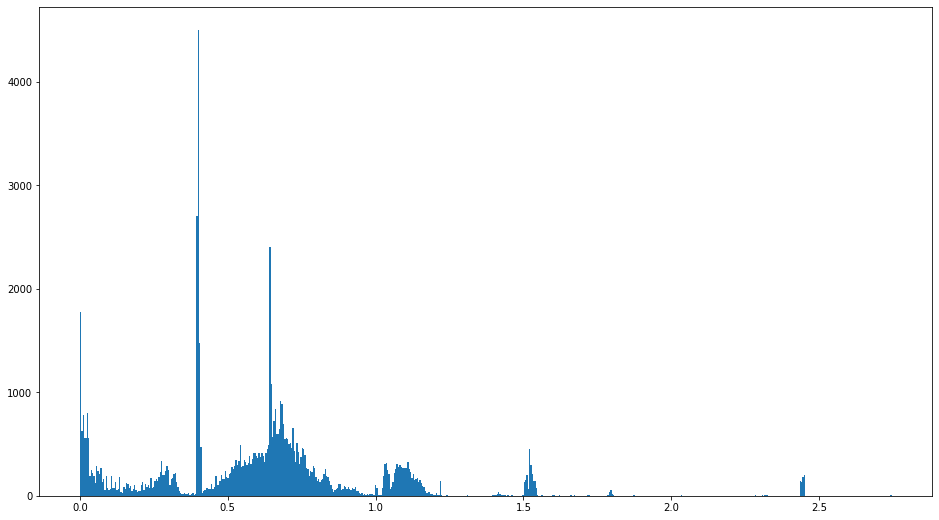

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(sizes[sizes['log_size'] >= 0]['log_size'], 600)
#ax.set_xlim([0, upper_three_halves])
plt.show()

In [5]:
df.groupby(F.col('method')).agg(
    F.count(F.col('id')).alias('count')
).withColumn(
    'perc', F.round(100 * F.col('count') / total, 3)
).sort(
    F.col('count').desc()
).select('method', 'count', 'perc').show()

+--------------------+--------+-----+
|              method|   count| perc|
+--------------------+--------+-----+
|                 GET|10190005|98.31|
|                POST|  139155|1.343|
|                HEAD|   34501|0.333|
|             OPTIONS|    1424|0.014|
|             CONNECT|      10|  0.0|
|                    |       7|  0.0|
|                   G|       5|  0.0|
|            PROPFIND|       3|  0.0|
|\x04\x01\x00P\x05...|       2|  0.0|
|\x16\x03\x01\x00^...|       2|  0.0|
|\x03\x00\x00/*\xE...|       2|  0.0|
|\x15\x03\x01\x00\...|       2|  0.0|
|                  t3|       2|  0.0|
|        \x05\x01\x00|       2|  0.0|
|\x17\x10\x05\x15J...|       1|  0.0|
|E\x00\x00J\x11,@\...|       1|  0.0|
|\x17\x03\x03\x01\...|       1|  0.0|
|\x03\x01\x02\x00\...|       1|  0.0|
|\x16\x03\x01\x00^...|       1|  0.0|
|\x16\x03\x01\x00\...|       1|  0.0|
+--------------------+--------+-----+
only showing top 20 rows



In [6]:
@F.udf(returnType=T.ArrayType(T.LongType()))
def separations(values):
    if len(values) < 2:
        seps = []
    else:
        values.sort()
        seps = [(end - start) for start, end in zip(values[:-1], values[1:])]

    return seps

In [7]:
df2 = df.groupby(
    F.col('host')
).agg(
    F.count(F.col('id')).alias('count'),
    F.collect_list(F.col('timestamp')).alias('ts')
).withColumn(
    'separations', separations(F.col('ts'))
).sort(
    F.col('count').desc()
).select('host', 'count', 'separations')

In [8]:
df2.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df2.columns]).show()

+----+-----+-----------+
|host|count|separations|
+----+-----+-----------+
|   0|    0|          0|
+----+-----+-----------+



In [9]:
ds = df2.toPandas()

In [10]:
ds.loc[:, ['count']].describe()

,count
count,258606.000000
mean,40.080864
std,995.379098
min,1.000000
25%,1.000000
50%,3.000000
75%,33.000000
max,353483.000000


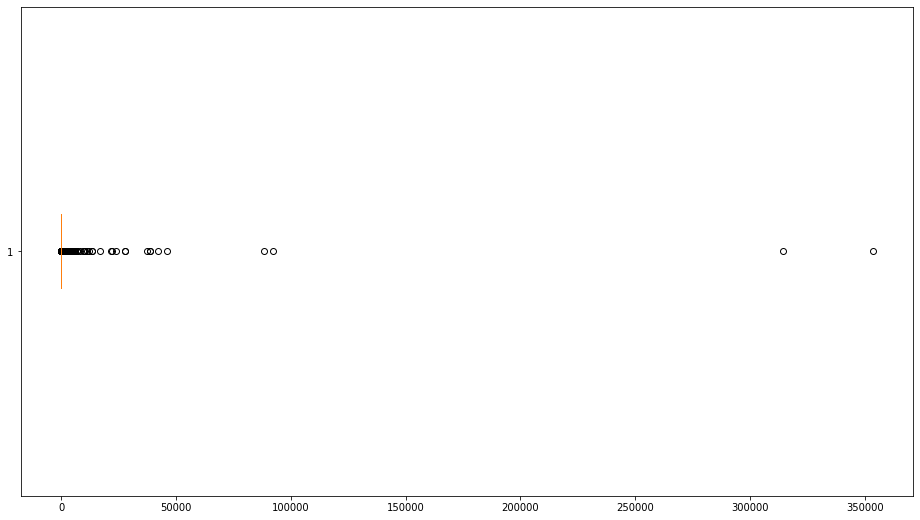

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.boxplot(ds['count'], vert=False)
plt.show()

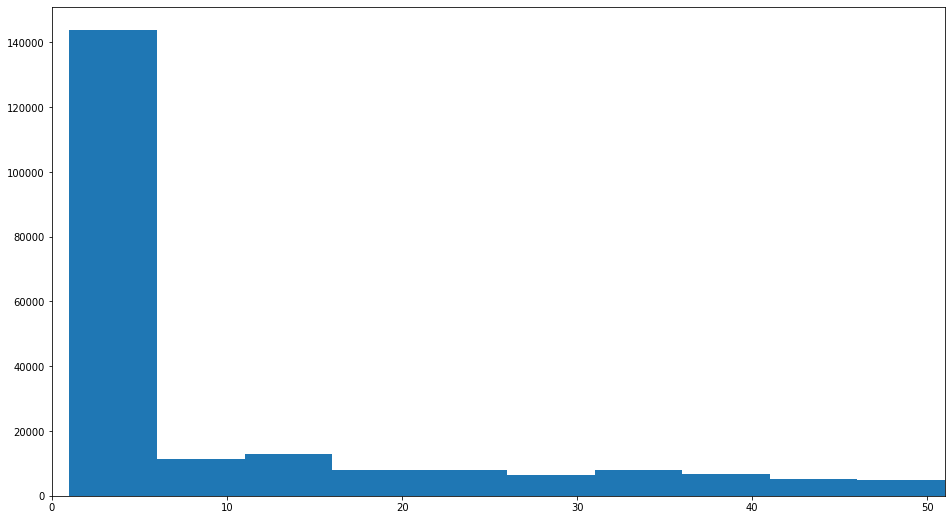

In [12]:
median = 3
iqr = 32
upper_three_halves = np.ceil(median + 1.5 * iqr)
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(ds[ds['count'] <= upper_three_halves]['count'])
ax.set_xlim([0, upper_three_halves])
plt.show()

In [24]:
df3 = df.where(
    F.col('method') == 'POST'
).groupby(
    F.col('host')
).agg(
    F.count(F.col('id')).alias('count'),
    F.collect_list(F.col('timestamp')).alias('ts')
).withColumn(
    'separations', separations(F.col('ts'))
).sort(
    F.col('count').desc()
).select('host', 'count', 'separations')

NameError: name 'separations' is not defined

In [14]:
df3.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df3.columns]).show()

+----+-----+-----------+
|host|count|separations|
+----+-----+-----------+
|   0|    0|          0|
+----+-----+-----------+



In [15]:
ds2 = df3.toPandas()

In [16]:
ds2['log_count'] = ds2['count'].apply(np.log)
ds2['med_sep'] = ds2['separations'].apply(np.median)
ds2['std_sep'] = ds2['separations'].apply(np.std)

/home/k0rtuz/Code/ml-cybersecurity/notebooks/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/k0rtuz/Code/ml-cybersecurity/notebooks/venv/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [17]:
ds2.loc[:, ['count', 'log_count', 'med_sep', 'std_sep']].describe()

,count,log_count,med_sep,std_sep
count,13765.000000,13765.000000,9357.000000,9357.000000
mean,10.109335,1.189971,1679.201560,3910.218308
std,120.313371,1.171383,17704.067168,16123.420446
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000,0.000000
50%,3.000000,1.098612,9.500000,9.604686
75%,6.000000,1.791759,30.000000,107.595274
max,11712.000000,9.368369,363637.000000,179246.000000


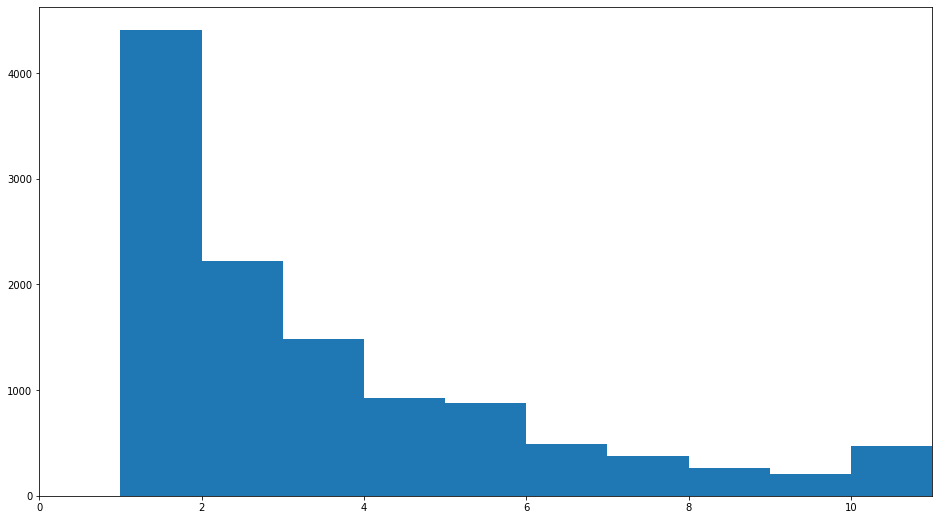

In [18]:
median = 3
iqr = 5
upper_three_halves = np.ceil(median + 1.5 * iqr)
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(ds2[ds2['count'] <= upper_three_halves]['count'])
ax.set_xlim([0, upper_three_halves])
plt.show()

NameError: name 'ds2' is not defined

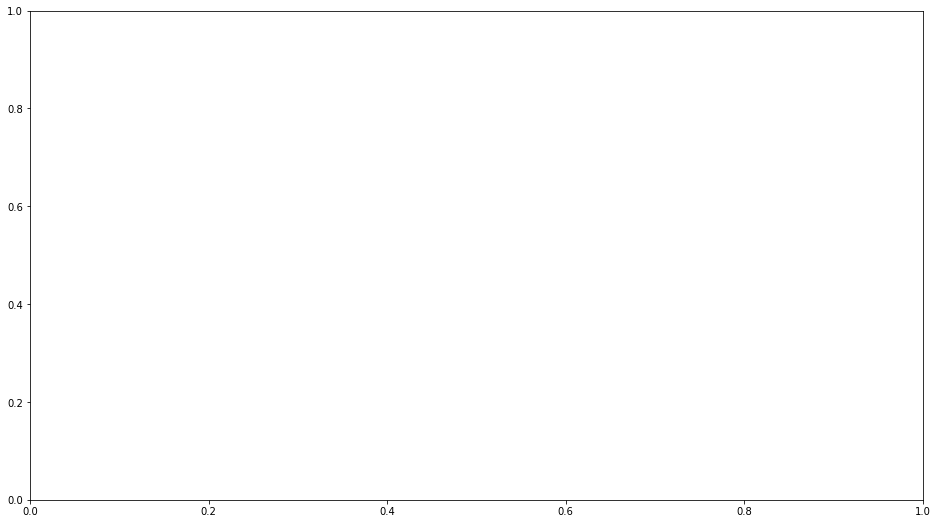

In [23]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(ds2['med_sep'])
ax.set_xlim([0, 10])
plt.show()

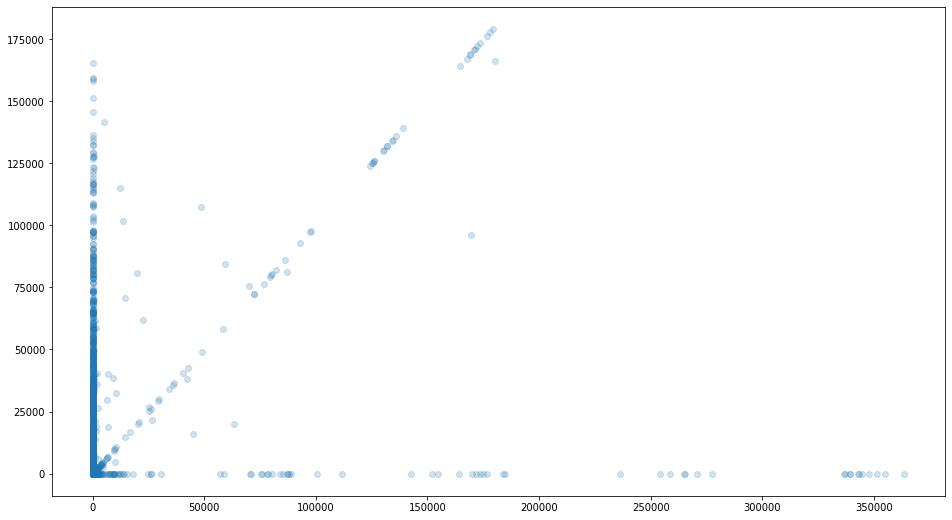

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(ds2['med_sep'], ds2['std_sep'], alpha=0.2)
#ax.set_xlim([0, 10])
#ax.set_ylim([0, 60])
plt.show()